# Clinical CDS Citation Accuracy Evaluation
Author: Ishaan Kejriwal  
Date: 10/8/2025  
Purpose: Evaluate whether CDS (Clinical Decision Support) model outputs include valid, verifiable citations ...


---

## Table of Contents
1. [Overview](#overview)  
2. [Metric Definition](#metric-definition)  
3. [Test Data](#test-data)  
4. [Evaluation Pipeline](#evaluation-pipeline)  
   - 4.1 [Citation Extraction](#citation-extraction)  
   - 4.2 [Validation Logic](#validation-logic)  
   - 4.3 [Scoring & Aggregation](#scoring-and-aggregation)  
5. [Run Evaluation](#run-evaluation)  
6. [Results & Summary](#results-and-summary)  
7. [Visualization](#visualization)  
8. [Appendix: Extensibility Notes](#appendix-extensibility-notes)

Import necessary libraries for notebook

In [3]:
from datetime import datetime
import re
import tldextract
from dataclasses import dataclass, asdict
from typing import List, Dict, Any, Tuple
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from pathlib import Path
import tempfile

## 1. Overview <a name="overview"></a>

This notebook implements a Citation Accuracy evaluation for CDS outputs.  
It mirrors a simple *auto-eval* structure:
- Define a small set of CDS prompts.
- Collect model outputs (mocked here for demonstration, but the same code will work with real outputs).
- Extract citations (URLs, DOIs, PubMed IDs) from each output.
- Validate citations against a configurable **allow-list of evidence domains** (e.g., `nih.gov`, `who.int`, `nice.org.uk`) and basic format checks.
- Aggregate metrics: percentage of responses with at least one citation, percentage of citations from approved domains, and per-prompt breakdowns.

## 2. Metric Definition <a name="metric-definition"></a>

**Metric:** *Citation Accuracy*  
**Objective:** Ensure CDS outputs contain valid, verifiable evidence sources supporting key statements or recommendations.

**What we check:**
- Presence of at least one citation.
- Type of citation: URL, DOI, PubMed ID (PMID), or mixed.
- Domain validity for URLs: belongs to an approved evidence source list (configurable).
- (Optional) Reachability checks with HTTP `HEAD` requests *(disabled in this demo; enable if network is available in your environment)*.

**Recommended summary KPIs:**
- `% responses with ≥1 citation`
- `% citations on approved domains`
- `avg citations per response`
- `distribution of citation types (URL/DOI/PMID)`

**Suggested pass criteria (tunable):**
- `≥ 95%` responses include at least one citation
- `≥ 90%` of URLs are from approved domains

## 3. Test Data <a name="test-data"></a>

For a quick, reproducible demo, we define a small set of CDS prompts and mock model outputs.  
Replace the `MOCK_MODEL_OUTPUTS` with your real model responses (e.g., API calls or logged outputs).

In [4]:
# Minimal example prompts (edit/expand as needed)
PROMPTS = [
    "Should ACE inhibitors be used during pregnancy? Provide sources.",
    "What is the recommended metformin dosing in renal impairment? Cite guidelines.",
    "Is it safe to co-administer aspirin and warfarin? Include evidence.",
    "Provide discharge anticoagulation guidance for AF patients. Cite sources.",
    "Give triage guidance for suspected sepsis in the ED with references."
]

# Mock model outputs to demonstrate both valid and invalid citations.
# Replace with real outputs to evaluate your system.
MOCK_MODEL_OUTPUTS = [
    # 1 - Valid NIH/WHO links + DOI
    """
    ACE inhibitors are generally contraindicated in pregnancy due to risk of fetal toxicity.
    See NIH guidance: https://www.ncbi.nlm.nih.gov/books/NBK431051/
    WHO maternal care overview: https://www.who.int/health-topics/maternal-health#tab=tab_1
    DOI: 10.1056/NEJMoa055202
    """,

    # 2 - Mixed: one invalid domain, one NICE (valid), one PubMed ID
    """
    In renal impairment, metformin dosing should be reduced for eGFR <45, and discontinued if <30.
    NICE guideline: https://www.nice.org.uk/guidance/ng28  
    Example blog (not approved): http://randommedblog.io/metformin  
    PMID: 21617112
    """,

    # 3 - No citations
    """
    Aspirin and warfarin co-administration increases bleeding risk; avoid unless benefits outweigh risks.
    """,

    # 4 - All URLs but non-approved domains
    """
    For AF discharge anticoagulation, refer to standard protocols:
    http://example.com/af-anticoagulation  
    https://somehealthsite.net/afib-coumadin
    """,

    # 5 - Valid CDC and NIH, plus DOI-like string and PubMed format variation
    """
    For suspected sepsis, initiate early broad-spectrum antibiotics and fluids.
    CDC guidance: https://www.cdc.gov/sepsis/  
    NIH resources: https://www.ncbi.nlm.nih.gov/books/NBK598311/  
    DOI: 10.1001/jama.2016.0287 
    PubMed: PMID 28345952
    """
]

timestamp = datetime.now().isoformat(timespec="seconds")
timestamp

'2025-10-15T01:50:35'

## 4. Evaluation Pipeline <a name="evaluation-pipeline"></a>

We implement a small, reusable evaluation module:

### 4.1 Citation Extraction <a name="citation-extraction"></a>
- Use regex to find URLs, DOIs, and PMIDs in free text.

### 4.2 Validation Logic <a name="validation-logic"></a>
- URL domains are checked against an approved allow-list.  
- DOIs/PMIDs are validated by format only in this demo (no network calls).

### 4.3 Scoring & Aggregation <a name="scoring-and-aggregation"></a>
- Compute per-response stats and overall aggregates.

In [19]:
# -----------------------------
# Configuration
# -----------------------------
APPROVED_EVIDENCE_DOMAINS = {
    # Major health orgs & guidelines
    "nih.gov", "ncbi.nlm.nih.gov", "niddk.nih.gov", "nichd.nih.gov",
    "cdc.gov", "who.int", "nice.org.uk",
    # Peer-reviewed journals/publishers (examples, extend as needed)
    "nejm.org", "jamanetwork.com", "bmj.com", "thelancet.com", "nature.com"
}

# Regex patterns for citations
# URL pattern:
# - Supports http/https/ftp
# - Excludes common private IP ranges
# - Captures both IPv4 public addresses and DNS hostnames
URL_PATTERN = re.compile(r"""
    (?:(?:https?|ftp)://)                   # protocol
    (?:\S+(?::\S*)?@)?                    # optional user:pass@
    (?:
        #Public IPv4
        (?:(?!10(?:\.\d{1,3}){3})
           (?!127(?:\.\d{1,3}){3})
           (?!169\.254(?:\.\d{1,3}){2})
           (?!192\.168(?:\.\d{1,3}){2})
           (?!172\.(?:1[6-9]|2\d|3[0-1])(?:\.\d{1,3}){2})
           (?:[1-9]\d?|1\d\d|2[01]\d|22[0-3])
           (?:\.(?:1?\d{1,2}|2[0-4]\d|25[0-5])){2}
           (?:\.(?:[1-9]\d?|1\d\d|2[0-4]\d|25[0-5]))
        )
        |
        #Hostname with unicode letters/numbers and hypens, dot-separated
        (?:(?:[a-z\u00a1-\uffff0-9]-*)*[a-z\u00a1-\uffff0-9]+
           (?:\.(?:[a-z\u00a1-\uffff0-9]-*)*[a-z\u00a1-\uffff0-9]+)*
           \.(?:[a-z\u00a1-\uffff]{2,})
        )
    )
    (?::\d{2,5})?                          # port
    (?:/[^\s]*)?                            # path
""", re.IGNORECASE | re.VERBOSE)

#DOI pattern
# - Standard Crossref-style prefix "10." plus 4–9 digits, then a slash and a
#   permissive set of DOI-safe characters.
DOI_PATTERN = re.compile(
    r'\b(?:doi:\s*)?(10\.\d{4,9}/[-._;()/:A-Z0-9]+)\b',
    re.IGNORECASE
)

# PMID pattern:
# - Accepts optional "PMID" label with punctuation, then a 5–9 digit ID.
# - Captures only the numeric group for downstream use.
PMID_PATTERN = re.compile(
    r'\b(?:pubmed:\s*)?(?:pmid[:\s]*)?([0-9]{7,8})\b',
    re.IGNORECASE
)

@dataclass
class Citation:
    #Structured representation of a citation artifact found in text.
    kind: str      # "url" | "doi" | "pmid"
    value: str     # Raw matched value (full URL, DOI string, or numeric PMID)
    domain: str = "" # Normalized domain for URLs; empty otherwise
    on_allow_list: bool = False # True if URL domain is approved; non-URL True by format

def extract_urls(text: str) -> List[str]:
    #Return all URL strings found in the text.
    return [m.group(0) for m in URL_PATTERN.finditer(text or "")]

def extract_dois(text: str) -> List[str]:
    #Return all DOI strings found in the text.
    return [m.group(0) for m in DOI_PATTERN.finditer(text or "")]

def extract_pmids(text: str) -> List[str]:
    # Return only the numeric group
    return [m.group(1) for m in PMID_PATTERN.finditer(text or "")]

def normalize_domain(url: str) -> str:
    ext = tldextract.extract(url)
    # Reconstruct the registered domain (domain + suffix)
    if ext.suffix:
        return f"{ext.domain}.{ext.suffix}"
    return ext.domain

def validate_url_domain(url: str) -> Tuple[str, bool]:
    # Determine whether a URL's registrable domain is on the allow-list.
    dom = normalize_domain(url)
    return dom, (dom in APPROVED_EVIDENCE_DOMAINS)

def extract_and_validate_citations(text: str) -> List[Citation]:
    """
    Parse text for URLs, DOIs, and PMIDs, and flag URL allow-list status.

    Behavior
    --------
    - URLs: included with their normalized `domain` and `on_allow_list` set
      based on APPROVED_EVIDENCE_DOMAINS.
    - DOIs/PMIDs: considered format-valid and marked `on_allow_list=True`
      (since allow-list pertains to URL hostnames only).

    Returns
    -------
    List[Citation]
        Structured citations in appearance order: URLs, then DOIs, then PMIDs.
    """
    citations: List[Citation] = []

    for u in extract_urls(text):
        dom, ok = validate_url_domain(u)
        citations.append(Citation(kind="url", value=u, domain=dom, on_allow_list=ok))
    for d in extract_dois(text):
        citations.append(Citation(kind="doi", value=d, domain="", on_allow_list=True))  # format OK
    for p in extract_pmids(text):
        citations.append(Citation(kind="pmid", value=p, domain="", on_allow_list=True)) # format OK

    return citations

def score_response(text: str) -> Dict[str, Any]:
    cits = extract_and_validate_citations(text)
    # Totals by kind
    n_total = len(cits)
    n_urls = sum(1 for c in cits if c.kind == "url")
    n_dois = sum(1 for c in cits if c.kind == "doi")
    n_pmids = sum(1 for c in cits if c.kind == "pmid")
    
    # Allowed counts:
    # - URLs must be on the allow-list
    # - DOIs/PMIDs are considered allowed (format-valid)
    n_allowed = sum(1 for c in cits if (c.kind != "url") or c.on_allow_list)  # URL must be on allow list; DOIs/PMIDs format-OK
    n_allowed_urls = sum(1 for c in cits if (c.kind == "url" and c.on_allow_list))
    n_urls_total = n_urls

    # Percentages with NaN protection when denominator is zero
    has_citation = n_total > 0
    pct_allowed_over_all = (n_allowed / n_total) * 100 if n_total > 0 else np.nan
    pct_allowed_over_urls = (n_allowed_urls / n_urls_total) * 100 if n_urls_total > 0 else np.nan

    return {
        "has_citation": has_citation,
        "n_total_citations": n_total,
        "n_url": n_urls,
        "n_doi": n_dois,
        "n_pmid": n_pmids,
        "n_allowed_over_all": n_allowed,
        "n_allowed_urls": n_allowed_urls,
        "pct_allowed_over_all": pct_allowed_over_all,
        "pct_allowed_over_urls": pct_allowed_over_urls,
        "citations_detail": [asdict(c) for c in cits],
    }

### Citation Quality Metrics Overview

This section above computes simple quality metrics over citations found in the model’s response text.

#### Metrics

| Metric | Type | Description |
|---------|------|-------------|
| **has_citation** | `bool` | Whether any citation (URL, DOI, or PMID) was found. |
| **n_total_citations** | `int` | Total count of all citation artifacts found. |
| **n_url**, **n_doi**, **n_pmid** | `int` | Counts by citation type. |
| **n_allowed_over_all** | `int` | Number of citations considered “allowed.” <br> - All DOIs and PMIDs (format-valid) are counted as allowed. <br> - Only URLs whose domain is on the allow-list are counted as allowed. |
| **n_allowed_urls** | `int` | Number of URLs specifically that are on the allow-list. |
| **pct_allowed_over_all** | `float` | Percentage of allowed citations out of all citations (`NaN` if none). |
| **pct_allowed_over_urls** | `float` | Percentage of allow-listed URLs among all URLs (`NaN` if no URLs). |
| **citations_detail** | `List[dict]` | A list of serialized `Citation` entries (`asdict`) for inspection. |

#### Notes

- DOI and PMID entries are treated as **allowed by format** because the allow-list only applies to URL hostnames.  
- If you need to resolve DOIs to their underlying host for domain validation, add a resolver step *upstream* before scoring.

---


## 5. Run Evaluation <a name="run-evaluation"></a>

Run the evaluation pipeline over all prompts and outputs.  
The resulting DataFrame provides per-item metrics and a nested column with full citation details.

In [20]:
records = []
for i, (prompt, output) in enumerate(zip(PROMPTS, MOCK_MODEL_OUTPUTS), start=1):
    score = score_response(output)
    record = {
        "id": i,
        "prompt": prompt,
        "has_citation": score["has_citation"],
        "n_total_citations": score["n_total_citations"],
        "n_url": score["n_url"],
        "n_doi": score["n_doi"],
        "n_pmid": score["n_pmid"],
        "n_allowed_over_all": score["n_allowed_over_all"],
        "n_allowed_urls": score["n_allowed_urls"],
        "pct_allowed_over_all": score["pct_allowed_over_all"],
        "pct_allowed_over_urls": score["pct_allowed_over_urls"],
        "citations_detail": score["citations_detail"],
        "output": output.strip(),
    }
    records.append(record)

df = pd.DataFrame(records)
df

,id,prompt,has_citation,n_total_citations,n_url,n_doi,n_pmid,n_allowed_over_all,n_allowed_urls,pct_allowed_over_all,pct_allowed_over_urls,citations_detail,output
0,1,Should ACE inhibitors be used during pregnancy...,True,3,2,1,0,3,2,100.000000,100.0,"[{'kind': 'url', 'value': 'https://www.ncbi.nl...",ACE inhibitors are generally contraindicated i...
1,2,What is the recommended metformin dosing in re...,True,3,2,0,1,2,1,66.666667,50.0,"[{'kind': 'url', 'value': 'https://www.nice.or...","In renal impairment, metformin dosing should b..."
2,3,Is it safe to co-administer aspirin and warfar...,False,0,0,0,0,0,0,NaN,NaN,[],Aspirin and warfarin co-administration increas...
3,4,Provide discharge anticoagulation guidance for...,True,2,2,0,0,0,0,0.000000,0.0,"[{'kind': 'url', 'value': 'http://example.com/...","For AF discharge anticoagulation, refer to sta..."
4,5,Give triage guidance for suspected sepsis in t...,True,4,2,1,1,4,2,100.000000,100.0,"[{'kind': 'url', 'value': 'https://www.cdc.gov...","For suspected sepsis, initiate early broad-spe..."


## 6. Results & Summary <a name="results-and-summary"></a>

We compute headline KPIs across the evaluated set.  
You can adapt pass/fail thresholds to your organizational targets (e.g., `≥95%` responses with ≥1 citation).

In [22]:
def safe_mean(series):
    s = series.dropna()
    return s.mean() if len(s) else np.nan

summary = {
    "responses_total": len(df),
    "responses_with_citation_pct": 100 * df["has_citation"].mean(),
    "avg_citations_per_response": df["n_total_citations"].mean(),
    "avg_pct_allowed_over_all": safe_mean(df["pct_allowed_over_all"]),
    "avg_pct_allowed_over_urls": safe_mean(df["pct_allowed_over_urls"]),
}

summary

{'responses_total': 5,
 'responses_with_citation_pct': 80.0,
 'avg_citations_per_response': 2.4,
 'avg_pct_allowed_over_all': 66.66666666666666,
 'avg_pct_allowed_over_urls': 62.5}

## 7. Visualization <a name="visualization"></a>

The chart below displays the count of **approved** vs **non-approved** citations per response.  
*Note:* We use matplotlib with default styles and a single plot, per constraints.

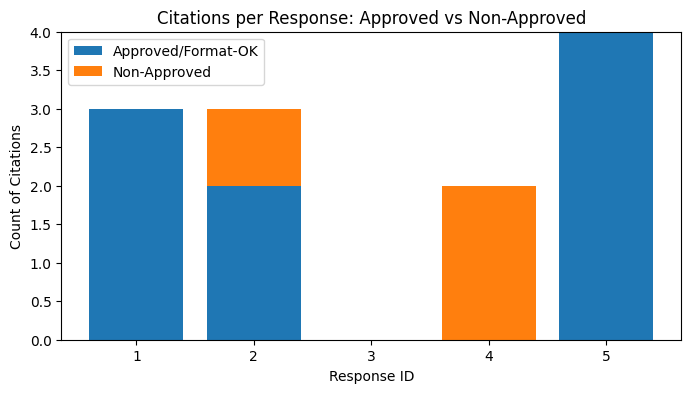

In [23]:
approved = df["n_allowed_over_all"]
non_approved = df["n_total_citations"] - df["n_allowed_over_all"]

x = df["id"].astype(str)

plt.figure(figsize=(8, 4))
plt.bar(x, approved, label="Approved/Format-OK")
plt.bar(x, non_approved, bottom=approved, label="Non-Approved")
plt.title("Citations per Response: Approved vs Non-Approved")
plt.xlabel("Response ID")
plt.ylabel("Count of Citations")
plt.legend()
plt.show()

## 8. Appendix: Extensibility Notes <a name="appendix-extensibility-notes"></a>

- Approved domains: Extend `APPROVED_EVIDENCE_DOMAINS` to include your institution’s preferred sources (e.g., specialty societies).  
- Reachability checks: If network access is allowed, add HTTP `HEAD` requests to confirm `200 OK` for each URL.  
- Evidence Concordance (optional): Map each prompt to a reference snippet and compute semantic similarity (e.g., TF–IDF cosine).  
- Response Time (optional): Wrap generation calls with a timer and log per-prompt latency and percentiles.  
- Audit trails: Persist `df` to CSV and JSON for audit or re-review workflows.

In [14]:
results_path_csv = Path("citation_eval_results.csv")
results_path_json = Path("citation_eval_results.json")

try:
    df.to_csv(results_path_csv, index=False)
    df.to_json(results_path_json, orient="records", indent=2)
except OSError:
    # fallback that always exists (Windows/macOS/Linux)
    tmpdir = Path(tempfile.gettempdir())
    results_path_csv = tmpdir / "citation_eval_results.csv"
    results_path_json = tmpdir / "citation_eval_results.json"
    df.to_csv(results_path_csv, index=False)
    df.to_json(results_path_json, orient="records", indent=2)

print("Saved CSV to:", results_path_csv)
print("Saved JSON to:", results_path_json)

Saved CSV to: citation_eval_results.csv
Saved JSON to: citation_eval_results.json
